## Expert Knowledge Worker

## Extra Jupyter Notebook - Day 4.5 - switch out Chroma for FAISS!

FAISS is Facebook AI Similarity Search

In [4]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
# install faiss-cpu!
# Mac users - this may fail if you don't have a recent version of MacOS
# In which case I recommend you skip this lab -- FAISS is not essential! (Or upgrade MacOS if you wish..)

!pip install faiss-cpu

   ---------------------------------------- 0.0/18.9 MB ? eta -:--:--
    --------------------------------------- 0.3/18.9 MB ? eta -:--:--
   - -------------------------------------- 0.8/18.9 MB 2.2 MB/s eta 0:00:09
   -- ------------------------------------- 1.0/18.9 MB 1.9 MB/s eta 0:00:10
   -- ------------------------------------- 1.3/18.9 MB 1.9 MB/s eta 0:00:10
   --- ------------------------------------ 1.6/18.9 MB 1.6 MB/s eta 0:00:12
   --- ------------------------------------ 1.8/18.9 MB 1.7 MB/s eta 0:00:10
   ---- ----------------------------------- 2.1/18.9 MB 1.6 MB/s eta 0:00:11
   ----- ---------------------------------- 2.6/18.9 MB 1.6 MB/s eta 0:00:11
   ------ --------------------------------- 3.1/18.9 MB 1.7 MB/s eta 0:00:10
   ------- -------------------------------- 3.7/18.9 MB 1.8 MB/s eta 0:00:09
   -------- ------------------------------- 3.9/18.9 MB 1.8 MB/s eta 0:00:09
   --------- ------------------------------ 4.5/18.9 MB 1.8 MB/s eta 0:00:09
   ----------

In [6]:
# imports for langchain

from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
# from langchain_chroma import Chroma
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from langchain_classic.memory import ConversationBufferMemory
from langchain_classic.chains import ConversationalRetrievalChain

from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

In [7]:
from langchain_classic.vectorstores import FAISS

In [8]:
# price is a factor for our company, so we're going to use a low cost model

MODEL = "gpt-5-nano"
db_name = "vector_db"

In [9]:
# Load environment variables in a file called .env

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [10]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our knowledgebase

folders = glob.glob("knowledge-base/*")

# With thanks to CG and Jon R, students on the course, for this fix needed for some users 
text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

In [11]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [12]:
len(chunks)

413

In [13]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: products, company, contracts, employees


## A sidenote on Embeddings, and "Auto-Encoding LLMs"

We will be mapping each chunk of text into a Vector that represents the meaning of the text, known as an embedding.

OpenAI offers a model to do this, which we will use by calling their API with some LangChain code.

This model is an example of an "Auto-Encoding LLM" which generates an output given a complete input.
It's different to all the other LLMs we've discussed today, which are known as "Auto-Regressive LLMs", and generate future tokens based only on past context.

Another example of an Auto-Encoding LLMs is BERT from Google. In addition to embedding, Auto-encoding LLMs are often used for classification.

### Sidenote

In week 8 we will return to RAG and vector embeddings, and we will use an open-source vector encoder so that the data never leaves our computer - that's an important consideration when building enterprise systems and the data needs to remain internal.

In [16]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is a popular open source Vector Database based on SQLLite

#embeddings = OpenAIEmbeddings()
from langchain_community.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
# Create vectorstore

# BEFORE
#vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)

# AFTER
vectorstore = FAISS.from_documents(chunks, embedding=embeddings)

total_vectors = vectorstore.index.ntotal
dimensions = vectorstore.index.d

print(f"There are {total_vectors} vectors with {dimensions:,} dimensions in the vector store")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16380\2457722188.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


There are 413 vectors with 384 dimensions in the vector store


In [17]:
# Prework
vectors = []
documents = []
doc_types = []
colors = []
color_map = {'products':'blue', 'employees':'green', 'contracts':'red', 'company':'orange'}

for i in range(total_vectors):
    vectors.append(vectorstore.index.reconstruct(i))
    doc_id = vectorstore.index_to_docstore_id[i]
    document = vectorstore.docstore.search(doc_id)
    documents.append(document.page_content)
    doc_type = document.metadata['doc_type']
    doc_types.append(doc_type)
    colors.append(color_map[doc_type])
    
vectors = np.array(vectors)

## Visualizing the Vector Store

Let's take a minute to look at the documents and their embedding vectors to see what's going on.

(As a sidenote, what we're really looking at here is the distribution of the Vectors generated by OpenAIEmbeddings, retrieved from FAISS. So there's no surprise that they look the same whether they are "from" FAISS or Chroma.)

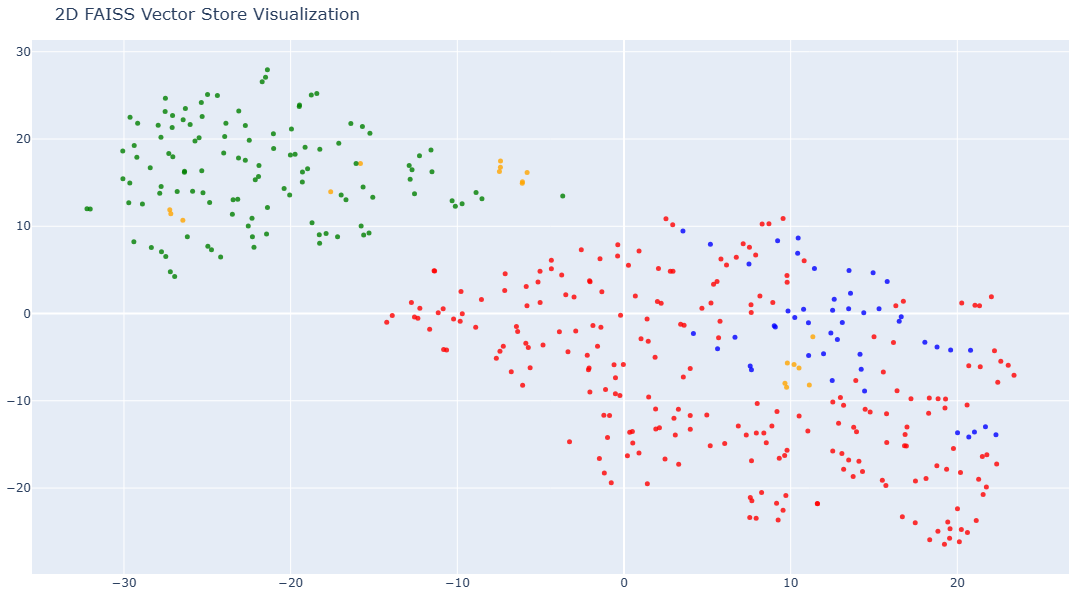

In [20]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D FAISS Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)
fig.show()

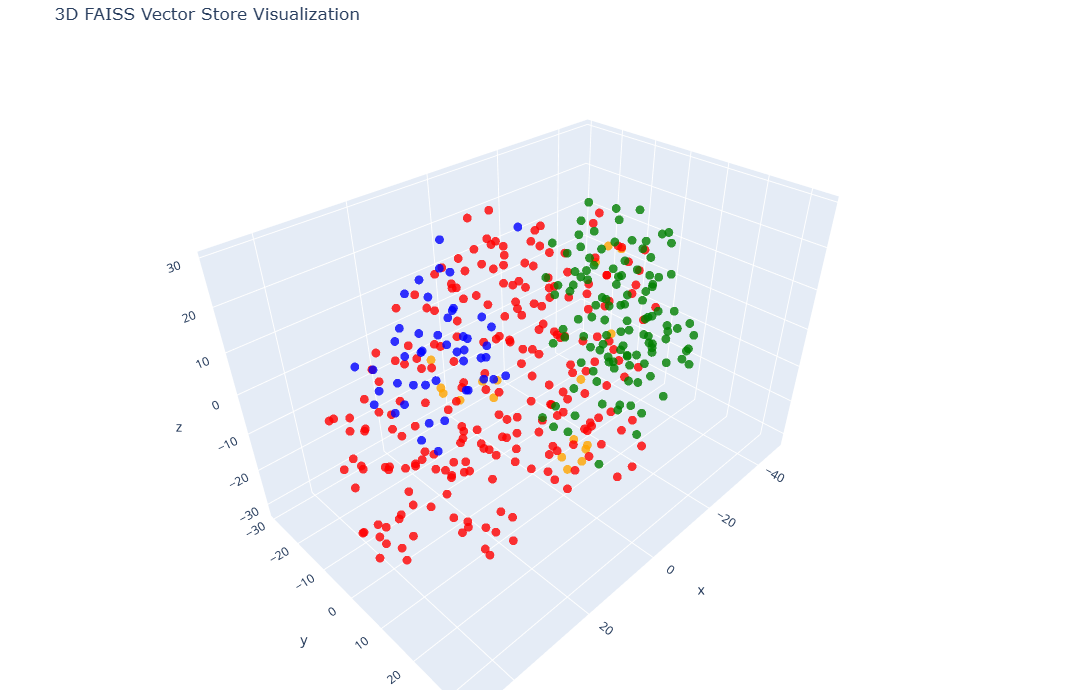

In [21]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D FAISS Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## Time to use LangChain to bring it all together

In [22]:
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16380\4268784041.py:5: LangChainDeprecationWarning:

Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/



In [23]:
query = "Can you describe Insurellm in a few sentences"
result = conversation_chain.invoke({"question":query})
print(result["answer"])

Insurellm is a San Francisco–based insurance tech company founded in 2015 by Avery Lancaster. It operates as a lean, profitable, remote-first organization with about 32 employees and offices in San Francisco, New York, Austin, Chicago, and Denver. The company offers eight insurance software products across multiple lines—Carllm, Homellm, Lifellm (AI-powered underwriting), Healthllm, and Bizllm among them—to help insurers modernize portals and operations. Its focus is on sustainable growth and operational excellence, with Lifellm highlighting its AI-driven approach to life insurance.


In [24]:
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

## Now we will bring this up in Gradio using the Chat interface -

A quick and easy way to prototype a chat with an LLM

In [25]:
# Wrapping that in a function

def chat(message, history):
    result = conversation_chain.invoke({"question": message})
    return result["answer"]

In [27]:
# And in Gradio:

view = gr.ChatInterface(chat).launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.
